<a href="https://colab.research.google.com/github/itzelts/2025-AM158-PSETS/blob/main/AM158_PSET3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install runtime dependencies (bound to the current kernel)
%pip install numpy matplotlib tqdm gymnasium cvxpy

# Problem set 3: DQN, Policy gradient and its variants

**Due: 11:59pm, November 2, 2025**

In the last PSET of reinforcement learning, you will implement the DQN algorithm together with vanilla policy gradient (REINFORCE) and its variants. In the last problem you will train a half-cheetah with stable baseline 3 package.

- Problem 1 requires implementing DQN and double DQN. **TODOs:**
  
  - 1.1 Finish vanilla DQN (20 pt)
  - 1.2 Finish double DQN (5 pt)

- Problem 2 verify the policy gradient theory and requires implementing REINFORCE with learned value function. **TODOs:**
  
  - 2.1 Verify different policy gradient estimator (15 pt)
  - 2.2 Implement REINFORCE with learned baseline (10 pt)

- Problem 3 requires implementing vanilla on-policy actor-critic algorithm. **TODOs:**
  - 3.1 Implement vanilla actor-critic (25 pt)

All of these three algorithms works on `gym`'s `Acrobot-v1` environments.

- Problem 4 requires implementing PPO algorithm. **TODOs:**
  - 4.1 Implement PPO-cliping (25 pt)

- Problem 5 **(Bonus)** help you try stable baseline 3 on `gym`'s `Half-cheetah-v4` environment. **TODOs:**
  - 5.1 Tune the parameter in stable baseline 3 (**Note the training can take 15 min**) (20 pt)
  

## Problem 1: DQN

In this problem you will implement DQN on `Acrobot-v1` environment using `gym`.

### Algorithm recap

1. **Q-network**
   - Function approximator $Q_\theta(s,a)$ for action values (here: a small MLP).

2. **Target network**
   - A copy of the online network with parameters $\theta^-$ that are updates periodically to stabilize training.

3. **Experience replay**
   - A replay buffer of transitions $(s,a,r,s',\text{done})$. Sample i.i.d. minibatches to break temporal correlations.

4. **Behavior policy**
   - $\epsilon$-greedy: with probability $\epsilon$ choose a random action; otherwise choose $ \arg\max_a Q_\theta(s,a) $.

5. **TD targets**
   - **Standard DQN**:
     $$
     y = r + \gamma \max_{a'} Q_{\theta^-}(s', a')
     $$
   - **Double DQN**:
     $$
     a^\star = \arg\max_{a'} Q_{\theta}(s', a'), \quad
     y = r + \gamma \, Q_{\theta^-}(s', a^\star)
     $$
     “Online net selects, target net evaluates” reduces overestimation. In comparison to Double Q-learning, the weights of the second network $\theta$ are replaced with the weights of the target network $\theta^−$ for the evaluation of the current greedy policy. The update to the target network stays unchanged from DQN, and remains a periodic copy of the online network.

6. **Loss & optimization**
   - Regress $Q_\theta(s,a)$ to target $y$ using MSE loss; backpropagate to update $\theta$.

### Environment & action space

- **Env**: `Acrobot-v1` (double pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/acrobot/)
- **Observation**: 6D —- $\cos\theta_1, \sin\theta_1, \cos\theta_2, \sin\theta_2, \dot\theta_1, \dot\theta_2$  
- **Actions**: Discrete 3 actions —- torques $-1, 0, +1$  
- **Reward**: $-1$ per step until the goal is reached (or the episode times out)


### 1.1 Implement DQN with gym

**TODO:** Fill in the three TODO blocks.
- implement a simple MLP
- implement the replaybuffer class
- implement the main algorithm

All the given code is for reference. If you find it inconvenient feel free to write yourself.

Note the final average return should be around $-100$.

[Env] Acrobot-v1 | obs_dim=6, n_actions=3
[Ep   10] eps=0.951  return=-500.0  avg_ret(10)=-497.1  avg_loss≈4.8478
[Ep   20] eps=0.905  return=-335.0  avg_ret(10)=-471.0  avg_loss≈10.6864
[Ep   30] eps=0.860  return=-294.0  avg_ret(10)=-468.9  avg_loss≈3.1604
[Ep   40] eps=0.818  return=-275.0  avg_ret(10)=-373.5  avg_loss≈6.9012
[Ep   50] eps=0.778  return=-333.0  avg_ret(10)=-393.7  avg_loss≈7.4361
[Ep   60] eps=0.740  return=-410.0  avg_ret(10)=-402.6  avg_loss≈7.7102
[Ep   70] eps=0.704  return=-287.0  avg_ret(10)=-290.1  avg_loss≈3.9325
[Ep   80] eps=0.670  return=-180.0  avg_ret(10)=-305.4  avg_loss≈4.5453
[Ep   90] eps=0.637  return=-233.0  avg_ret(10)=-232.7  avg_loss≈5.0477
[Ep  100] eps=0.606  return=-204.0  avg_ret(10)=-267.8  avg_loss≈5.5193
[Ep  110] eps=0.576  return=-236.0  avg_ret(10)=-186.4  avg_loss≈5.2657
[Ep  120] eps=0.548  return=-252.0  avg_ret(10)=-205.2  avg_loss≈4.9269
[Ep  130] eps=0.521  return=-343.0  avg_ret(10)=-204.9  avg_loss≈4.8255
[Ep  140] eps=0.496  

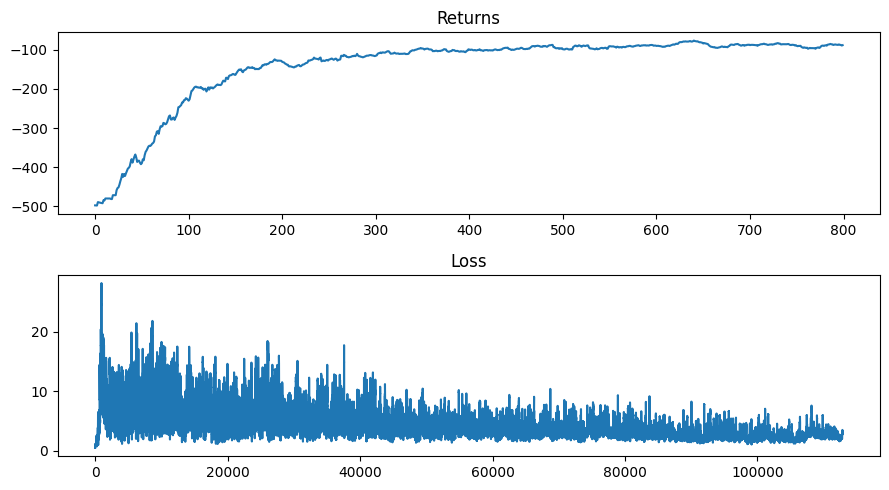

In [2]:

import os, random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy

# ------------------- config  -------------------
ENV_ID                 = "Acrobot-v1"
SEED                   = 42
GAMMA                  = 0.995
LR                     = 1e-3
BATCH_SIZE             = 64
BUFFER_SIZE            = 100_000
START_TRAINING_AFTER   = 1000       # warmup steps
TARGET_UPDATE_FREQ     = 10       # steps (hard update)
MAX_EPISODES           = 800

GRAD_CLIP_NORM         = 10.0
PRINT_EVERY_EPISODES   = 10

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

state_dims = int(np.prod(env.observation_space.shape))  # Acrobot: 6
num_actions = env.action_space.n                        # Acrobot: 3
print(f"[Env] {ENV_ID} | obs_dim={state_dims}, n_actions={num_actions}")

# ------------------- gym environment -> tensor -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info

env = TWrapper(env)

# ------------------- Q network -------------------
class QNetwork(nn.Module):
    #########################################
    #TODO 1.1: Implement a simple MLP
    #########################################
    def __init__(self, state_dim: int, n_actions: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


q_net = QNetwork(state_dims, num_actions)
tgt_net = copy.deepcopy(q_net).eval()

# ------------------- simple replay buffer -------------------
class ReplayBuffer:
    def __init__(self, capacity=BUFFER_SIZE):
        self.capacity, self.mem, self.pos = capacity, [], 0
    #########################################
    #TODO 1.1: Implement a ReplayBuffer
    # capacity: max number of transitions to store
    # mem: list of transitions
    # pos: next position to insert
    # push: add a transition
    # sample: random sample a batch of transitions
    #########################################
    def push(self, s, a, r, s2, d):
        s = s.detach().cpu()
        a = a.detach().cpu()
        r = r.detach().cpu()
        s2 = s2.detach().cpu()
        d = d.detach().cpu()

        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = (s, a, r, s2, d)
        self.pos = (self.pos + 1) % self.capacity

    def __len__(self):
        return len(self.mem)

    def sample(self, batch_size: int):
        batch = random.sample(self.mem, batch_size)
        s, a, r, s2, d = zip(*batch)
        states = torch.cat(s,  dim=0)
        actions = torch.cat(a,  dim=0).long()
        rewards = torch.cat(r,  dim=0)
        next_states = torch.cat(s2, dim=0)
        dones = torch.cat(d,  dim=0)
        return states, actions, rewards, next_states, dones

buffer = ReplayBuffer()
optim  = Adam(q_net.parameters(), lr=LR)

# ------------------- greedy / epsilon-greedy -------------------
@torch.no_grad()
def act_epsilon_greedy(state: torch.Tensor, eps: float) -> torch.Tensor:
    if torch.rand(1).item() < eps:
        return torch.randint(num_actions, (1, 1))
    q = q_net(state)
    return torch.argmax(q, dim=-1, keepdim=True)

# ------------------- train loop (Double DQN target) -------------------
def train():
    returns_hist, loss_hist = [], []

    EPS_START, EPS_END, EPS_DECAY = 1.0, 0.05, 0.995

    global_step = 0


    for ep in range(1, MAX_EPISODES + 1):
        #########################################
        #TODO 1.1: Implement the main algorithm here
        #########################################
        state, _ = env.reset()
        done = torch.tensor([[False]], dtype=torch.bool)
        ep_return = 0.0
        eps = max(EPS_END, EPS_START * (EPS_DECAY ** ep))

        while not done.item():
            # behavior
            action = act_epsilon_greedy(state, eps)

            # env step
            next_state, reward, done, _ = env.step(action)
            ep_return += reward.item()

            buffer.push(state, action, reward, next_state, done)

            state = next_state
            global_step += 1

            if len(buffer) >= BATCH_SIZE and global_step >= START_TRAINING_AFTER:
                states, actions, rewards, next_states, dones = buffer.sample(BATCH_SIZE)

                # Current Q(s,a)
                q_pred = q_net(states).gather(1, actions)

                # DQN target:
                with torch.no_grad():
                    next_q_target = tgt_net(next_states)
                    next_q_max = next_q_target.max(dim=1, keepdim=True).values
                    targets = rewards + GAMMA * (~dones).float() * next_q_max

                # loss & optimize
                loss = F.mse_loss(q_pred, targets)
                optim.zero_grad(set_to_none=True)
                loss.backward()
                nn.utils.clip_grad_norm_(q_net.parameters(), GRAD_CLIP_NORM)
                optim.step()

                loss_hist.append(loss.item())

                # hard target update (by step)
                if global_step % TARGET_UPDATE_FREQ == 0:
                    tgt_net.load_state_dict(q_net.state_dict())

        returns_hist.append(ep_return)

        if ep % PRINT_EVERY_EPISODES == 0:
            avg_ret = np.mean(returns_hist[-PRINT_EVERY_EPISODES:])
            avg_loss = np.mean(loss_hist[-PRINT_EVERY_EPISODES*10:]) if len(loss_hist) else float('nan')
            print(f"[Ep {ep:4d}] eps={eps:.3f}  return={ep_return:.1f}  avg_ret({PRINT_EVERY_EPISODES})={avg_ret:.1f}  avg_loss≈{avg_loss:.4f}")


    plot_stats({"Returns": returns_hist, "Loss": loss_hist})

# ------------------- plotting -------------------
def _smooth(x, w=21):
    if len(x) < w: return x
    k = w // 2
    return [np.mean(x[max(0, i-k):min(len(x), i+k+1)]) for i in range(len(x))]

def plot_stats(stats: dict, win: int = 21):
    fig, axs = plt.subplots(len(stats), 1, figsize=(9, 5), tight_layout=True)
    if len(stats) == 1: axs = [axs]
    for ax, (k, v) in zip(axs, stats.items()):
        ax.plot(_smooth(v, win))
        ax.set_title(k)
    plt.show()
    plt.close()

train()
env.close()


### 1.2 Change classical DQN to double DQN

Use **two networks**:
- **Online** network selects the next action  
  $$
  a^* = \arg\max_{a'} Q_{\text{online}}(s', a').
  $$
- **Target** network evaluates that action  
  $$
  y_{\text{DDQN}} = r + \gamma\, Q_{\text{target}}(s', a^*).
  $$
  
This decoupling reduces overestimation while keeping the update otherwise unchanged.

In the code you will only need to change several lines.

**TODO:** Comment the vanilla DQN and write Double DQN at the same place.

[Env] Acrobot-v1 | obs_dim=6, n_actions=3
[Ep   10] eps=0.951  return=-500.0  avg_ret(10)=-500.0  avg_loss≈10.3862
[Ep   20] eps=0.905  return=-452.0  avg_ret(10)=-492.3  avg_loss≈14.9927
[Ep   30] eps=0.860  return=-500.0  avg_ret(10)=-499.2  avg_loss≈16.5453
[Ep   40] eps=0.818  return=-415.0  avg_ret(10)=-423.3  avg_loss≈9.9757
[Ep   50] eps=0.778  return=-337.0  avg_ret(10)=-399.3  avg_loss≈10.0658
[Ep   60] eps=0.740  return=-225.0  avg_ret(10)=-410.9  avg_loss≈15.4497
[Ep   70] eps=0.704  return=-500.0  avg_ret(10)=-376.9  avg_loss≈11.3480
[Ep   80] eps=0.670  return=-326.0  avg_ret(10)=-361.7  avg_loss≈11.0675
[Ep   90] eps=0.637  return=-211.0  avg_ret(10)=-278.3  avg_loss≈23.1765
[Ep  100] eps=0.606  return=-246.0  avg_ret(10)=-274.8  avg_loss≈9.0595
[Ep  110] eps=0.576  return=-286.0  avg_ret(10)=-257.4  avg_loss≈11.3769
[Ep  120] eps=0.548  return=-238.0  avg_ret(10)=-221.3  avg_loss≈10.2180
[Ep  130] eps=0.521  return=-222.0  avg_ret(10)=-188.6  avg_loss≈9.3528
[Ep  140] ep

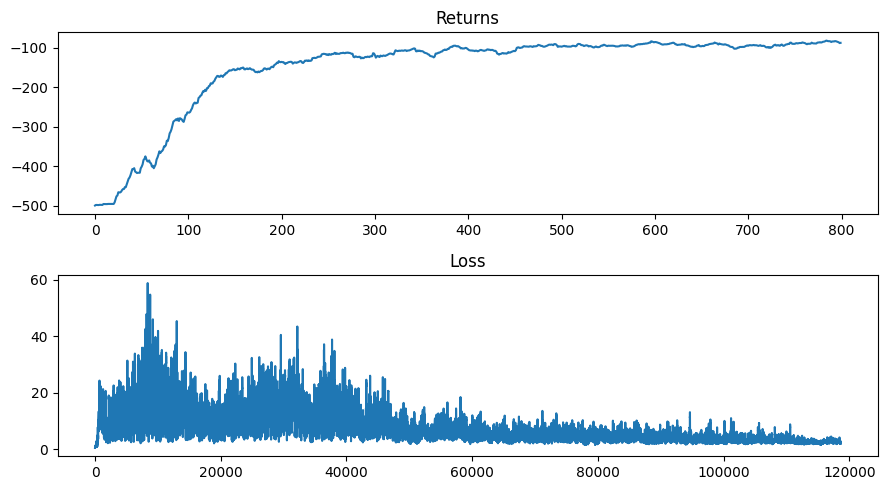

In [3]:

import os, random
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy

# ------------------- config  -------------------
ENV_ID                 = "Acrobot-v1"
SEED                   = 42
GAMMA                  = 0.995
LR                     = 1e-3
BATCH_SIZE             = 64
BUFFER_SIZE            = 100_000
START_TRAINING_AFTER   = 1000       # warmup steps
TARGET_UPDATE_FREQ     = 10       # steps (hard update)
MAX_EPISODES           = 800

GRAD_CLIP_NORM         = 10.0
PRINT_EVERY_EPISODES   = 10

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

state_dims = int(np.prod(env.observation_space.shape))  # Acrobot: 6
num_actions = env.action_space.n                        # Acrobot: 3
print(f"[Env] {ENV_ID} | obs_dim={state_dims}, n_actions={num_actions}")

# ------------------- gym environment -> tensor -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info

env = TWrapper(env)

# ------------------- Q network -------------------
class QNetwork(nn.Module):
    #########################################
    #TODO 1.1: Implement a simple MLP
    #########################################
    def __init__(self, state_dim: int, n_actions: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


q_net = QNetwork(state_dims, num_actions)
tgt_net = copy.deepcopy(q_net).eval()

# ------------------- simple replay buffer -------------------
class ReplayBuffer:
    def __init__(self, capacity=BUFFER_SIZE):
        self.capacity, self.mem, self.pos = capacity, [], 0
    #########################################
    #TODO 1.1: Implement a ReplayBuffer
    # capacity: max number of transitions to store
    # mem: list of transitions
    # pos: next position to insert
    # push: add a transition
    # sample: random sample a batch of transitions
    #########################################
    def push(self, s, a, r, s2, d):
        s = s.detach().cpu()
        a = a.detach().cpu()
        r = r.detach().cpu()
        s2 = s2.detach().cpu()
        d = d.detach().cpu()

        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = (s, a, r, s2, d)
        self.pos = (self.pos + 1) % self.capacity

    def __len__(self):
        return len(self.mem)

    def sample(self, batch_size: int):
        batch = random.sample(self.mem, batch_size)
        s, a, r, s2, d = zip(*batch)
        states = torch.cat(s,  dim=0)
        actions = torch.cat(a,  dim=0).long()
        rewards = torch.cat(r,  dim=0)
        next_states = torch.cat(s2, dim=0)
        dones = torch.cat(d,  dim=0)
        return states, actions, rewards, next_states, dones

buffer = ReplayBuffer()
optim  = Adam(q_net.parameters(), lr=LR)

# ------------------- greedy / epsilon-greedy -------------------
@torch.no_grad()
def act_epsilon_greedy(state: torch.Tensor, eps: float) -> torch.Tensor:
    if torch.rand(1).item() < eps:
        return torch.randint(num_actions, (1, 1))
    q = q_net(state)
    return torch.argmax(q, dim=-1, keepdim=True)

# ------------------- train loop (Double DQN target) -------------------
def train():
    returns_hist, loss_hist = [], []

    EPS_START, EPS_END, EPS_DECAY = 1.0, 0.05, 0.995

    global_step = 0


    for ep in range(1, MAX_EPISODES + 1):
        #########################################
        #TODO 1.1: Implement the main algorithm here
        #########################################
        state, _ = env.reset()
        done = torch.tensor([[False]], dtype=torch.bool)
        ep_return = 0.0
        eps = max(EPS_END, EPS_START * (EPS_DECAY ** ep))

        while not done.item():
            # behavior: epsilon-greedy
            action = act_epsilon_greedy(state, eps)

            # env step
            next_state, reward, done, _ = env.step(action)
            ep_return += reward.item()

            buffer.push(state, action, reward, next_state, done)

            state = next_state
            global_step += 1

            if len(buffer) >= BATCH_SIZE and global_step >= START_TRAINING_AFTER:
                states, actions, rewards, next_states, dones = buffer.sample(BATCH_SIZE)

                # Current Q(s,a)
                q_pred = q_net(states).gather(1, actions)  # (B,1)

                # Double DQN target:
                with torch.no_grad():
                    # online net selects
                    next_q_online = q_net(next_states)
                    a_star = torch.argmax(next_q_online, dim=1, keepdim=True)
                    # target net evaluates
                    next_q_target = tgt_net(next_states).gather(1, a_star)
                    targets = rewards + GAMMA * (~dones).float() * next_q_target

                # loss & optimize
                loss = F.mse_loss(q_pred, targets)
                optim.zero_grad(set_to_none=True)
                loss.backward()
                nn.utils.clip_grad_norm_(q_net.parameters(), GRAD_CLIP_NORM)
                optim.step()

                loss_hist.append(loss.item())

                # hard target update (by step)
                if global_step % TARGET_UPDATE_FREQ == 0:
                    tgt_net.load_state_dict(q_net.state_dict())

        returns_hist.append(ep_return)

        if ep % PRINT_EVERY_EPISODES == 0:
            avg_ret = np.mean(returns_hist[-PRINT_EVERY_EPISODES:])
            avg_loss = np.mean(loss_hist[-PRINT_EVERY_EPISODES*10:]) if len(loss_hist) else float('nan')
            print(f"[Ep {ep:4d}] eps={eps:.3f}  return={ep_return:.1f}  avg_ret({PRINT_EVERY_EPISODES})={avg_ret:.1f}  avg_loss≈{avg_loss:.4f}")


    plot_stats({"Returns": returns_hist, "Loss": loss_hist})

# ------------------- plotting -------------------
def _smooth(x, w=21):
    if len(x) < w: return x
    k = w // 2
    return [np.mean(x[max(0, i-k):min(len(x), i+k+1)]) for i in range(len(x))]

def plot_stats(stats: dict, win: int = 21):
    fig, axs = plt.subplots(len(stats), 1, figsize=(9, 5), tight_layout=True)
    if len(stats) == 1: axs = [axs]
    for ax, (k, v) in zip(axs, stats.items()):
        ax.plot(_smooth(v, win))
        ax.set_title(k)
    plt.show()
    plt.close()

train()
env.close()


## Problem 2: Policy Gradient

<!-- #### reparameterization trick:

Let $x$ be a random variable whose distribution depends on $\theta$. Write this as $x\sim p_\theta(x)$. For any measurable $V:\mathcal X\to\mathbb R$,
$$
\mathbb{E}\big[V(f(\theta))\big] \;=\; \mathbb{E}_{x\sim p_\theta}[V(x)],
$$
where $p_\theta$ is the distribution of $x$ induced by $\theta$. This help us move complex functions from expectation to distribution.

Take the gradient gives us

$$
\nabla \mathbb{E}_{x\sim p_\theta}[V(x)] = \int \nabla p_\theta(x) V(x) dx = \int \nabla \ln(p_\theta(x)) V(x) p_\theta(x)dx = \mathbb{E}_{x\sim p_\theta}[V(x) \nabla \ln(p_\theta(x))]
$$

So now we only need to take derivative of the distribution.

### RL as an Expectation over Trajectories
The cost over a distribution of $s_0$ gives the definition of reward function $J$:

$$
\mathbb{E}_{s_0\sim\rho}[V^{\pi_\theta}(s_0)]
$$

But use the trick above we can rewrite that using trajectory. A trajectory is
$$
\tau=(s_0,a_0,s_1,a_1,\ldots,s_T),
$$
generated by initial state distribution $\rho$, policy $\pi_\theta(a\mid s)$, and dynamics $P(s'\mid s,a)$. The trajectory distribution is
$$
p_\theta(\tau)=\rho(s_0)\prod_{t=0}^{T-1}\pi_\theta(a_t\mid s_t)\,P(s_{t+1}\mid s_t,a_t).
$$
Define the discounted return
$$
G(\tau)=\sum_{t=0}^{T-1}\gamma^t\,r(s_t,a_t).
$$
Then the performance objective is
$$
\,J(\theta)=\mathbb{E}_{\tau\sim p_\theta}[G(\tau)]\,
$$

This helps move the $\theta$ to distribution.
 -->

### Recall: Policy-Gradient Theorem

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \nabla_\theta \mathbb{E}_{\tau\sim p_\theta}[G(\tau)]
= \mathbb{E}_{\tau\sim p_\theta}\!\left[G(\tau)\,\nabla_\theta\log p_\theta(\tau)\right] \\
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G(\tau)\right] \\
\end{aligned} \tag{F1}
$$

This is the first gradient formulation we arrive at (here $G(\tau) = R(\tau)$ and $R(\tau)$ is the notation used in Lecture notes). A naive collary is the using causality to change that to return-to-go:

$$
\begin{aligned}
\nabla_\theta J(\theta)
&= \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,G_t(\tau)\right]
\end{aligned} \tag{F2}
$$

where $G_t=\sum_{k=t}^{T-1}\gamma^{k-t}r(s_k,a_k)$ and $d^{\pi_\theta}$ is the discounted state-visitation distribution. Next, we observe that

$$
\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\,b(s_t)\right]=0,
$$

<!-- This is because condition on $s_t$, $b(s_t)$ is a constant inside expectation, and $\mathbb{E}_{a_t\sim\pi_\theta}\!\left[\nabla_\theta\log\pi_\theta(a_t\mid s_t)\right]=0$.  -->

Plug in the "baseline" $b(s_t)$ into the policy gradient gives us

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(G_t(\tau)- b(s_t))\right] \tag{F3}
$$

In practice most of the time people use the learned value function for the baseline.

### Policy gradient theorem (extended)

Next we talk about another 3 chosen of policy gradient:

From (F2) gradient we can easily see that $Q(s_t,a_t) = \mathbb{E}[G_t(\tau)]$, so plug in F2 gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,Q(s_t,a_t)\right] \tag{F4}
$$

And followed by previous explanation of baseline, we can define $A(s_t,a_t) = Q(s_t,a_t) - V(s_t)$, thus we arrive the *advantage function* gradient.
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,A(s_t,a_t)\right] \tag{F5}
$$

The last formulation is by observing that
$$
\mathbb{E}[Q(s_t,a_t)] = \mathbb{E}[r(s_t,a_t) + \gamma V(s_{t+1})]
$$

apply baseline to it gives us
$$
\mathbb{E}_{\tau\sim p_\theta}\!\left[\sum_{t=0}^{T-1}\gamma^t \nabla_\theta\log\pi_\theta(a_t\mid s_t)\,(r(s_t,a_t) + \gamma V(s_{t+1}) - V(s_t))\right] \tag{F6}
$$

### 2.1 Convergence of Different Policy-Gradient Estimators

We study a random walk on a ring. Let $\mathcal{S}=\mathbb{Z}_N$ and $\mathcal{A}=\{L,R\}$. The dynamics and rewards are
$$
s_{t+1}\equiv s_t+\begin{cases}
+1 & \text{if }a_t = R, \\
-1 & \text{if }a_t = L,
\end{cases}\ (\mathrm{mod}\,N),\qquad
r_t \equiv \begin{cases}
r_\text{terminal} & \text{if done} \\
r_\text{step} & \text{otherwise}
\end{cases},\quad \gamma\in(0,1).
$$

Because this is tabular, Bellman consistency (Eq. 1.21) yields a linear system $AV=b$ (as in PSET1, Problem 4). Solving gives the exact values $V$, and $Q$ follows by one-step lookahead.

**TODO:**
1. Implement a minimal MLP policy ($x=s/N\to\pi_\theta(\cdot\mid s)$) with a Softmax output.  
2. Implement six MC gradient estimators: REINFORCE, return-to-go, baseline with $V$, using $Q$, advantage $Q{-}V$, and TD-residual.  
3. Plot per-parameter sample std and the running-mean error $\|\bar g_k-\nabla_\theta J\|_2$ vs. episodes, plus $|\bar J_k-J_{\text{true}}|$.
   $$\bar g_k = \frac{1}{k} \sum_i^k g_i, \quad \bar J_k = \frac{1}{k} \sum_i^k J_i$$
   
4. Comment on what you see, and explain it intuitively.

Note:

Here we provide the function `build_system`, `get_V_and_J` and `get_Q` for calculate the true value / action value. `finite_difference_grad` for approximate the true objective / gradient by finite difference. And also `logp_single` and `score_matrix_batch` for calculate $\nabla J_\theta$ in a batched manner (You can also use for-loop, but that takes quite long run time). But feel free to use your own code.


    g1  | mean(std)=2.906e+01  median(std)=2.560e+01  max(std)=5.919e+01
    g2  | mean(std)=6.840e+01  median(std)=5.943e+01  max(std)=1.401e+02
    g3  | mean(std)=4.645e+01  median(std)=4.262e+01  max(std)=9.387e+01
    g4  | mean(std)=2.520e+01  median(std)=2.220e+01  max(std)=5.128e+01
    g5  | mean(std)=1.813e+01  median(std)=1.595e+01  max(std)=3.698e+01
    g6  | mean(std)=1.813e+01  median(std)=1.595e+01  max(std)=3.698e+01


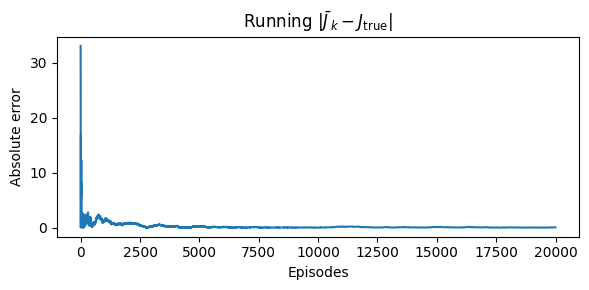

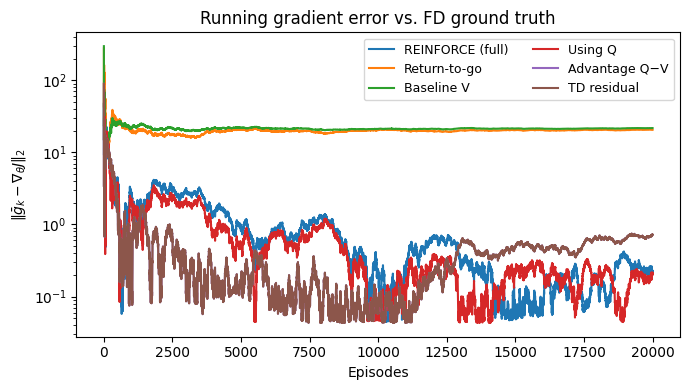

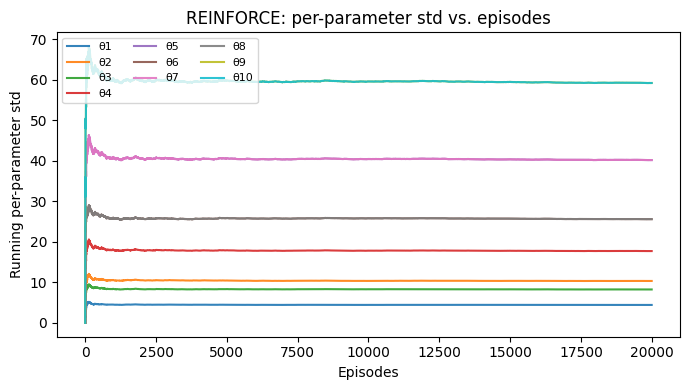

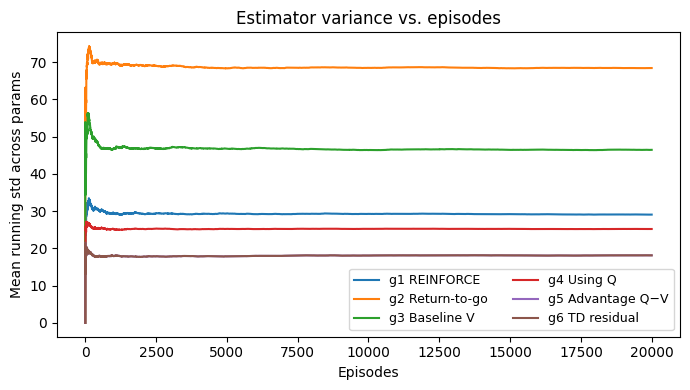

In [12]:
import math, random
from typing import Tuple, List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import matplotlib.pyplot as plt
from torch.func import functional_call, vmap, jacrev


# ----------------- utilities -----------------
def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

# ----------------- policy network (last layer Softmax) -----------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 2.1: Implement the policy network
    #########################################
    def __init__(self, hidden: int = 16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
            nn.Softmax(dim=-1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 1:
            x = x.unsqueeze(1)
        return self.net(x.float())


# ----------------- DP: exact J(θ) using policy p_s -----------------
def build_system(model: PolicyNet, N: int, gamma: float,
                 running_reward: float, terminal_reward: float):
    """
    In tabular case, we could build A,b directly from the bellman's equations (eq 1.21 in lecture note).
    Build linear system A V = b for states s=1..N-1.
    Transition probabilities p_s come from the torch policy (Right prob).
    """
    model.eval()
    with torch.no_grad():
        s_idx = torch.arange(1, N, dtype=torch.float32)
        x = s_idx / float(N)                  # (N-1,)
        pi = model(x)                         # (N-1, 2)
        p = pi[:, 1].cpu().numpy()            # P(right | s)
        q = (1.0 - p)                         # P(left  | s)

    A = np.zeros((N-1, N-1), dtype=np.float64)
    b = np.zeros(N-1, dtype=np.float64)

    if N - 1 == 1:
        A[0, 0] = 1.0
        b[0] = terminal_reward
        return A, b

    # s = 1 (index 0)
    A[0, 0] = 1.0
    A[0, 1] = -gamma * p[0]
    b[0] = q[0] * terminal_reward + p[0] * running_reward

    # s = 2..N-2 (indices 1..N-3)
    for s in range(2, N-1):
        i = s - 1
        A[i, i]   = 1.0
        A[i, i-1] = -gamma * q[i]
        A[i, i+1] = -gamma * p[i]
        b[i]      = running_reward

    # s = N-1 (index N-2)
    i = N - 2
    A[i, i]   = 1.0
    A[i, i-1] = -gamma * q[i]
    b[i]      = p[i] * terminal_reward + q[i] * running_reward
    return A, b

def get_V_and_J(model: PolicyNet, N: int, gamma: float,
                running_reward: float, terminal_reward: float):
    """Solve A V = b; return V(s) for s=1..N-1 and uniform-start J."""
    A, b = build_system(model, N, gamma, running_reward, terminal_reward)
    V = np.linalg.solve(A, b)
    return V, float(V.mean())

def get_Q(model: PolicyNet, N: int, gamma: float,
          running_reward: float, terminal_reward: float):
    """
    Q(s,a) via one-step lookahead using V from DP.
    Returns Q for s=1..N-1 (shape (N-1, 2)).
    """
    V, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    V_full = np.zeros(N + 1)
    V_full[1:N] = V
    s = np.arange(1, N, dtype=np.int64)
    sL, sR = s - 1, s + 1
    rL = np.where(sL == 0, terminal_reward, running_reward)
    rR = np.where(sR == N, terminal_reward, running_reward)
    Q = np.empty((N-1, 2), dtype=np.float64)
    Q[:, 0] = rL + gamma * V_full[sL]
    Q[:, 1] = rR + gamma * V_full[sR]
    return Q

# ----------------- Finite-difference gradient on θ (torch) -----------------
def finite_difference_grad(model: PolicyNet, N: int, gamma: float,
                           running_reward: float, terminal_reward: float,
                           eps: float = 1e-4, relative: bool = False,
                           scheme: str = 'central'):
    """
    Finite-difference ∇θ J where θ is the concatenated torch parameter vector.
    Supports central or forward difference. Optional relative step size.
    """
    theta0 = parameters_to_vector(model.parameters()).detach().clone()
    _, J0 = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
    grad = torch.zeros_like(theta0)

    for i in range(theta0.numel()):
        base = float(abs(theta0[i])) if relative else 1.0
        h = eps * max(1.0, base)

        if scheme.lower() == 'central':
            th_p = theta0.clone(); th_p[i] += h
            th_m = theta0.clone(); th_m[i] -= h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            vector_to_parameters(th_m, model.parameters())
            Jm = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - Jm) / (2.0 * h)
        elif scheme.lower() == 'forward':
            th_p = theta0.clone(); th_p[i] += h
            vector_to_parameters(th_p, model.parameters())
            Jp = get_V_and_J(model, N, gamma, running_reward, terminal_reward)[1]
            grad[i] = (Jp - J0) / h
        else:
            raise ValueError("scheme must be 'central' or 'forward'")

    # restore original params
    vector_to_parameters(theta0, model.parameters())
    return J0, grad.detach()

# ----------------- MC gradient estimators (REINFORCE family) -----------------
def mc_grad_estimators(model: PolicyNet, N: int, s0_batch: torch.Tensor, gamma: float,
                       step_cost: float, terminal_reward: float,
                       V: torch.Tensor = None, Q: torch.Tensor = None):
    """
    We compute per-sample score vectors using autograd by calling backward()
    on log π(a_t|s_t) to obtain ∇θ log π(a_t|s_t).

    Returns (all numpy arrays):
      g1..g6: (B, P) per-episode gradient samples; J: (B,)
        g1: full-return REINFORCE
        g2: return-to-go REINFORCE (via cumulative scores H)
        g3: baseline with V(s_t)
        g4: use Q(s_t, a_t)
        g5: use Advantage A = Q − V
        g6: use TD residual δ_t = r_t + γ V(s_{t+1}) − V(s_t)
    """
    device = next(model.parameters()).device
    model.eval()

    names, base_params = zip(*list(model.named_parameters()))
    # Detach so these are leaf tensors, then turn grad on (required by jacrev)
    params = tuple(p.detach().requires_grad_(True) for p in base_params)
    P = sum(p.numel() for p in params)

    B = int(s0_batch.numel())
    s    = s0_batch.to(device).clone()
    done = (s == 0) | (s == N)

    H  = torch.zeros(B, P, device=device)  # cumulative score per-episode
    g1 = torch.zeros(B, P, device=device)
    g2 = torch.zeros(B, P, device=device)
    g3 = torch.zeros(B, P, device=device)
    g4 = torch.zeros(B, P, device=device)
    g5 = torch.zeros(B, P, device=device)
    g6 = torch.zeros(B, P, device=device)
    J  = torch.zeros(B,   device=device)
    gpw= torch.ones (B,   device=device)  # γ^t

    if V is not None:
        V = V.to(device)     # shape N+1, suggest V[0]=V[N]=0
    if Q is not None:
        Q = Q.to(device)     # shape (N+1,2), with Q(0,.)=Q(N,.)=0 if you padded

    def logp_single(param_tensors, s_scalar: torch.Tensor, a_scalar: torch.Tensor):
        # Build a param dict for functional_call
        pmap = {n: t for n, t in zip(names, param_tensors)}
        x = (s_scalar.float() / float(N)).view(1, 1)
        probs = functional_call(model, pmap, (x,))    # (1,2)
        # Differentiable action selection via gather (avoid data-dependent indexing pitfalls)
        logp = probs.log().gather(1, a_scalar.long().view(1, 1)).squeeze()  # scalar
        return logp

    # Note: you may found this function useful, this calculate ∇θ log π(a_i|s_i) in a batch manner
    def score_matrix_batch(active_s: torch.Tensor, active_a: torch.Tensor) -> torch.Tensor:
        """
        Returns (B_act, P) where each row is ∇θ log π(a_i|s_i),
        computed efficiently via vmap(jacrev) over (s,a).
        """
        # jac is a pytree of tensors matching param shapes, each with leading dim B_act
        jac = vmap(jacrev(logp_single), in_dims=(None, 0, 0))(params, active_s, active_a)
        # Flatten each param’s jacobian and concatenate along feature dim
        parts = [g.reshape(g.shape[0], -1) for g in jac]
        return torch.cat(parts, dim=1)  # (B_act, P)


    while not torch.all(done):
        idx = (~done).nonzero(as_tuple=False).squeeze(1)
        if idx.numel() == 0:
            break

        # Sample actions for all active states in one forward pass
        x = (s[idx].float() / float(N)).unsqueeze(1)
        with torch.no_grad():
            probs = model(x)                            # (B_act, 2)
            a = torch.multinomial(probs, 1).squeeze(1) # (B_act,)

        # ∇θ log π(a|s): (B_act, P) using backward()
        score_mat = score_matrix_batch(s[idx], a)

        # Next state, termination, and rewards
        s_next   = s[idx] + torch.where(a == 1, 1, -1)
        term_any = (s_next == 0) | (s_next == N)
        r_t = torch.where(
            term_any,
            torch.tensor(terminal_reward, device=device),
            torch.tensor(step_cost, device=device)
        ).float()

        #########################################
        #TODO 2.1: Implement the six policy gradient estimators
        #########################################
        # discounted return J (per episode), using gamma^t * r_t
        J[idx] += gpw[idx] * r_t

        # maintain:
        #  - Ssum (for full-return REINFORCE)
        #  - H discounted score accumulator (for return-to-go trick)
        if 'Ssum' not in locals():
            Ssum = torch.zeros(B, P, device=device)
        Ssum[idx] += score_mat
        H[idx] = gamma * H[idx] + score_mat

        # convenience values for baselines
        v_s   = (V[s[idx].long()] if V is not None else None)
        v_sp1 = (V[s_next.long()] if V is not None else None)
        q_sa  = (Q[s[idx].long(), a.long()] if Q is not None else None)

        # g2: return-to-go REINFORCE
        g2[idx] += (r_t.unsqueeze(1)) * H[idx]

        #  g3: baseline with V(s_t)
        if V is not None:
            g3[idx] += (r_t.unsqueeze(1)) * H[idx] \
                       - ((v_s.unsqueeze(1)) * score_mat)

        # g4: use Q(s_t, a_t)
        if Q is not None:
            g4[idx] += (gpw[idx].unsqueeze(1)) * (q_sa.unsqueeze(1)) * score_mat

        # g5: advantage Q − V
        if (Q is not None) and (V is not None):
            adv = q_sa - v_s
            g5[idx] += (gpw[idx].unsqueeze(1)) * (adv.unsqueeze(1)) * score_mat

        # g6: TD residual
        if V is not None:
            delta = r_t + gamma * v_sp1 - v_s
            g6[idx] += (gpw[idx].unsqueeze(1)) * (delta.unsqueeze(1)) * score_mat

        # advance gamma^t and env
        gpw[idx] *= gamma
        s[idx] = s_next
        done[idx] = term_any

    g1 = (J.unsqueeze(1)) * Ssum

    return (g1.detach().cpu().numpy(),
            g2.detach().cpu().numpy(),
            (g3.detach().cpu().numpy() if V is not None else np.zeros_like(g2.detach().cpu().numpy())),
            (g4.detach().cpu().numpy() if Q is not None else np.zeros_like(g2.detach().cpu().numpy())),
            (g5.detach().cpu().numpy() if (V is not None and Q is not None) else np.zeros_like(g2.detach().cpu().numpy())),
            g6.detach().cpu().numpy() if V is not None else np.zeros_like(g2.detach().cpu().numpy()),
            J.detach().cpu().numpy())

# ----------------- main -----------------
set_seed(0)
device = torch.device("cpu")

# Environment
N = 10
gamma = 0.9
running_reward = -1.0
terminal_reward = 100.0

# Policy
model = PolicyNet(hidden=2).to(device)

# Exact J and FD gradient
J_true, grad_fd = finite_difference_grad(
    model, N, gamma, running_reward, terminal_reward,
    eps=1e-4, relative=True, scheme='central'
)

# Baselines from DP value V(s) and Q(s,a)
V_np, _ = get_V_and_J(model, N, gamma, running_reward, terminal_reward)
V = torch.tensor(np.concatenate(([0.0], V_np, [0.0])), dtype=torch.float32, device=device)  # V(0)=V(N)=0

Q_np = get_Q(model, N, gamma, running_reward, terminal_reward).astype(np.float32)
Q_t  = torch.tensor(Q_np, dtype=torch.float32, device=device)
zero_row = torch.zeros(1, 2, dtype=torch.float32, device=device)
Q = torch.cat([zero_row, Q_t, zero_row], dim=0)  # Q(0,.)=Q(N,.)=0

# Monte Carlo (batched episodes)
episodes = 20000  # adjust as needed
s0_batch = torch.randint(1, N, (episodes,), dtype=torch.int64, device=device)
g1, g2, g3, g4, g5, g6, J = mc_grad_estimators(
    model, N, s0_batch, gamma,
    step_cost=running_reward,
    terminal_reward=terminal_reward,
    V=V, Q=Q
)

#########################################
#TODO 2.1: Plot your result here
# 1. Print out the standard deviation of each gradient estimator
# 2. Plot the running error of the estimated J vs the true J, you may found np.cumsum(:, axis=0) / np.arange(1, len(J) + 1) useful
# 3. Plot the running error of each gradient estimator vs the FD gradient
#########################################

# 1) Per-parameter sample std (print concise summaries)
def pp_std(name, G):
    # G: (episodes, P)
    per_param_std = G.std(axis=0)
    print(f"{name:>6}  | mean(std)={per_param_std.mean():.3e}  "
          f"median(std)={np.median(per_param_std):.3e}  "
          f"max(std)={per_param_std.max():.3e}")

pp_std("g1", g1); pp_std("g2", g2); pp_std("g3", g3)
pp_std("g4", g4); pp_std("g5", g5); pp_std("g6", g6)

# 2) Running error of estimated J vs true J
J_running = np.cumsum(J) / np.arange(1, len(J) + 1)
J_err = np.abs(J_running - J_true)

plt.figure(figsize=(6,3))
plt.plot(J_err)
plt.title(r"Running $| \bar J_k - J_{\mathrm{true}} |$")
plt.xlabel("Episodes")
plt.ylabel("Absolute error")
plt.tight_layout()
plt.show()

# 3) Running error of each gradient estimator vs FD gradient
def running_grad_err(G, name):
    # running mean over episodes, compare to grad_fd
    cum = np.cumsum(G, axis=0)
    denom = np.arange(1, G.shape[0]+1)[:, None]
    Gbar = cum / denom
    err = np.linalg.norm(Gbar - grad_fd.cpu().numpy(), axis=1)
    plt.plot(err, label=name)

plt.figure(figsize=(7,4))
running_grad_err(g1, "REINFORCE (full)")
running_grad_err(g2, "Return-to-go")
running_grad_err(g3, "Baseline V")
running_grad_err(g4, "Using Q")
running_grad_err(g5, "Advantage Q−V")
running_grad_err(g6, "TD residual")
plt.yscale("log")
plt.xlabel("Episodes")
plt.ylabel(r"$\|\bar g_k - \nabla_\theta J\|_2$")
plt.title("Running gradient error vs. FD ground truth")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

def running_std(G):
    """
    G: (episodes, P) gradient samples for one estimator (e.g., g1)
    returns: (episodes, P) where [k, p] is std of the first k samples for param p
    """
    c1 = np.cumsum(G, axis=0)
    c2 = np.cumsum(G**2, axis=0)
    k  = np.arange(1, G.shape[0] + 1)[:, None]
    var = np.maximum(c2 / k - (c1 / k)**2, 0.0)
    return np.sqrt(var)


std_traces_g1 = running_std(g1)
plt.figure(figsize=(7,4))
for p in range(std_traces_g1.shape[1]):
    plt.plot(std_traces_g1[:, p], label=f"θ{p+1}", alpha=0.9)
plt.xlabel("Episodes")
plt.ylabel("Running per-parameter std")
plt.title("REINFORCE: per-parameter std vs. episodes")
plt.legend(ncol=3, fontsize=8)
plt.tight_layout()
plt.show()


def mean_running_std(G):
    return running_std(G).mean(axis=1)

plt.figure(figsize=(7,4))
plt.plot(mean_running_std(g1), label="g1 REINFORCE")
plt.plot(mean_running_std(g2), label="g2 Return-to-go")
plt.plot(mean_running_std(g3), label="g3 Baseline V")
plt.plot(mean_running_std(g4), label="g4 Using Q")
plt.plot(mean_running_std(g5), label="g5 Advantage Q−V")
plt.plot(mean_running_std(g6), label="g6 TD residual")
plt.xlabel("Episodes")
plt.ylabel("Mean running std across params")
plt.title("Estimator variance vs. episodes")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()





We see that in the first plot, $|\bar J_k-J_{\text{true}}|$, drops quickly and stays near zero so the return estimator is consistent and variance shrinks with averaging. Furthermore, we see that the REINFORCE/Using Q curves trend down toward
≪ 1 while Return-to-go and Baseline V flatten high indicating high bias. The TD-residual line is very low early (low variance) but drifts upward later. This can be explained by the classic bias–variance trade-off: bootstrapping reduces variance but can introduce bias as policy/critic shift.

For the six methods, we see the following:
* Best (lowest variance): `g5 ≈ g6` (advantage and TD-residual are identical here) where mean std ≈ 1.81e+01
* Then`g4` (using Q) about 2.52e+01
* Then `g1` (full-return REINFORCE) about 2.91e+01
* g3 (baseline V) helps vs g2 but is still large at about 4.65e+01
* worst is `g2` (return-to-go) about 6.84e+01

On the running-error plot, `g5/g6` track the FD gradient fastest; `g4` is next; `g1` eventually gets there; `g2` and `g3` stay much noisier.

We know that return-to-go is not guaranteed to have lower variance than full-return. In this MDP we have I think heavy-tailed returns. With `g2`, each score at time (t) is multiplied by its own tail return (G_t) and so when that tail has huge variability, it can amplify our per-step noise. In contrast, `g1` multiplies all scores by (J(\tau)) for the episode, which can be less noisy when the score sequence and the far-future rewards are only weakly aligned. Hence our ouputs can be explained a bit. And we do see `g3` drop below `g2`. But the baseline removes variance from state-value drift and so with very spiky terminal rewards, a lot of variance lives in the action-conditioned tail (G_t - \mathbb{E}[G_t!\mid!s_t]) anyway. Thus using Q or A = Q−V targets the action-conditioned part directly, which can explain why `g4` and especially `g5/g6` are much better!

### 2.2 REINFORCE algorithm

**Algorithm Recap — REINFORCE (Monte-Carlo Policy Gradient)**

1. **Policy network**  
   Stochastic policy $\pi_\theta(a\mid s)$

2. **Trajectory sampling**  
   Roll out episodes with $\pi_\theta$: $(s_1,a_1,r_1,\dots,s_T,a_T,r_T)$.

3. **Returns / advantages**
   - Monte-Carlo return:
     $$
     G_t=\sum_{t'=t}^{T}\gamma^{\,t'-t} r_{t'}.
     $$
   - Advantage: $A_t = G_t - b(s_t)$.

4. **Policy-gradient update**
   - Estimator:
     $$
     \hat g(\theta)=\frac{1}{N}\sum_{i=1}^{N}\sum_{t=1}^{T_i}
       \nabla_\theta \log \pi_\theta(a_t^{(i)}\mid s_t^{(i)})\, \gamma^t A_t^{(i)}.
     $$
   - Gradient ascent: $\theta \leftarrow \theta + \alpha\,\hat g(\theta)$.

5. **Learned value baseline (optional)**
   - Regress $V_\psi(s)$ to returns:
     $$
     \min_\psi \frac{1}{N}\sum_{i,t}\big(V_\psi(s_t^{(i)})-G_t^{(i)}\big)^2,
     \qquad A_t\!=\!G_t\!-\!V_\psi(s_t).
     $$

6. **Mini-batch training**
   - Collect $N$ episodes (or $M$ steps), compute $G_t/A_t$; optimize
     $$
     \mathcal{L}_{\text{PG}}(\theta)=
     -\frac{1}{N}\sum_{i,t}\log\pi_\theta(a_t^{(i)}\mid s_t^{(i)})\,A_t^{(i)}.
     $$

**TODO:**
- implement policy net and value net
- implement the main algorithm


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 400
BATCH_SIZE = 16
MAX_EP_LEN = 1000
VALUE_UPDATES = 10

GRAD_CLIP = 10.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.use_deterministic_algorithms(True)

# ------------------- tensor wrapper (given as a reference) -------------------
class TWrapper(gym.Wrapper):
    def __init__(self, env): super().__init__(env)
    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0), info
    def step(self, action):
        a = int(action.item()) if isinstance(action, torch.Tensor) else int(action)
        obs, r, term, trunc, info = self.env.step(a)
        done = bool(term or trunc)
        obs_t = torch.from_numpy(np.asarray(obs, np.float32)).unsqueeze(0)
        r_t   = torch.tensor([[r]], dtype=torch.float32)
        d_t   = torch.tensor([[done]], dtype=torch.bool)
        return obs_t, r_t, d_t, info

env = TWrapper(env)

# ------------------- discrete policy net (given as a reference) -------------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 2.2: Implement policy network
    #########################################
    def __init__(self, obs_dim: int, hidden: int, act_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, act_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x.float())

# ------------------- value baseline (given as a reference) -------------------
class ValueNet(nn.Module):
    #########################################
    #TODO 2.2: Implement value network
    #########################################
    def __init__(self, obs_dim: int, hidden: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x.float()).squeeze(-1)


policy = PolicyNet(obs_dim=obs_dim, hidden=HIDDEN, act_dim=act_dim).to(DEVICE)
vnet   = ValueNet(obs_dim=obs_dim, hidden=HIDDEN).to(DEVICE)

# ------------------- utils -------------------
def mc_returns_single_traj(R: torch.Tensor, gamma: float) -> torch.Tensor:
    """R: [T] -> G: [T], reverse within a single trajectory."""
    G = torch.zeros_like(R)
    running = 0.0
    for t in range(R.numel() - 1, -1, -1):
        running = R[t] + gamma * running
        G[t] = running
    return G

# ------------------- training -------------------
def train():
    #########################################
    #TODO 2.2: Implement vanilla REINFORCE algorithm
    #########################################
    policy.train(); vnet.train()
    optim_pi = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
    optim_v = torch.optim.Adam(vnet.parameters(),   lr=LR_VALUE)

    returns_history = []

    for epoch in range(1, MAX_EPOCHS + 1):
        #  collect a batch of episodes
        batch_obs = []
        batch_act = []
        batch_logp = []
        batch_R = []
        batch_G = []
        batch_gpow = []
        ep_returns = []

        ep_count = 0
        while ep_count < BATCH_SIZE:
            s, _ = env.reset()
            s = s.to(DEVICE)
            traj_obs, traj_act, traj_logp, traj_R, traj_gpow = [], [], [], [], []

            gpow = 1.0
            for t in range(MAX_EP_LEN):
                logits = policy(s.to(DEVICE))
                dist = Categorical(logits=logits)
                a = dist.sample()
                logp = dist.log_prob(a)

                s_next, r, done, _ = env.step(a)
                r = r.to(DEVICE).squeeze().item()

                traj_obs.append(s.squeeze(0))
                traj_act.append(a.squeeze(0))
                traj_logp.append(logp.squeeze(0))
                traj_R.append(torch.tensor(r, device=DEVICE, dtype=torch.float32))
                traj_gpow.append(torch.tensor(gpow, device=DEVICE, dtype=torch.float32))

                s = s_next.to(DEVICE)
                gpow *= GAMMA
                if done.item():
                    break

            # Monte-Carlo returns for this trajectory
            R = torch.stack(traj_R)
            G = mc_returns_single_traj(R, GAMMA)

            batch_obs.append(torch.stack(traj_obs))
            batch_act.append(torch.stack(traj_act))
            batch_logp.append(torch.stack(traj_logp))
            batch_R.append(R)
            batch_G.append(G)
            batch_gpow.append(torch.stack(traj_gpow))

            ep_returns.append(R.sum().item())
            ep_count += 1

        # concatenate batch
        O = torch.cat(batch_obs,  dim=0)
        A = torch.cat(batch_act,  dim=0)
        LOGP = torch.cat(batch_logp, dim=0)
        Gt = torch.cat(batch_G,    dim=0)
        GP = torch.cat(batch_gpow, dim=0)

        returns_history.append(np.mean(ep_returns))

        # value updates (fit V ≈ G)
        for _ in range(VALUE_UPDATES):
            Vpred = vnet(O)
            v_loss = F.mse_loss(Vpred, Gt)
            optim_v.zero_grad(set_to_none=True)
            v_loss.backward()
            nn.utils.clip_grad_norm_(vnet.parameters(), GRAD_CLIP)
            optim_v.step()

        # recompute baseline after value fit
        with torch.no_grad():
            Vpred = vnet(O)

        # policy update (REINFORCE with baseline)
        # advantages and standardization
        Ahat = (Gt - Vpred).detach()
        Ahat = (Ahat - Ahat.mean()) / (Ahat.std() + 1e-8)

        # gamma^t weighting
        pg_loss = -(LOGP * (GP * Ahat)).mean()

        optim_pi.zero_grad(set_to_none=True)
        pg_loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        optim_pi.step()

        if epoch % 10 == 0:
            print(f"[Epoch {epoch:03d}] "
                  f"Ret(mean)={np.mean(ep_returns):7.3f}  "
                  f"Vloss={v_loss.item():.3f}  "
                  f"Ploss={pg_loss.item():.3f}")

    print("Training finished.")
    return policy, vnet, returns_history

policy, vnet, returns_history = train()

def eval(policy, episodes=10, greedy=True, device=DEVICE, max_len=MAX_EP_LEN):
    env = gym.make("Acrobot-v1")
    policy.eval()
    succ, max_hs = [], []
    with torch.no_grad():
        for _ in range(episodes):
            o, _ = env.reset()
            ok, m = False, -1e9
            for _ in range(max_len):
                s = torch.as_tensor(o, dtype=torch.float32, device=device).unsqueeze(0)
                logits = policy(s)
                a = int(logits.argmax(-1)) if greedy else int(Categorical(logits=logits).sample())
                o, r, term, trunc, _ = env.step(a)
                c1, s1, c2, s2 = o[:4]; m = max(m, float(-c1 - (c1*c2 - s1*s2)))  # tip height
                if term or trunc: ok = bool(term); break
            succ.append(ok); max_hs.append(m)
    print(f"success={np.mean(succ):.1%}, mean_max_tip={np.mean(max_hs):.3f}")

eval(policy, episodes=100, greedy=True)

[Epoch 010] Ret(mean)=-353.812  Vloss=10593.923  Ploss=-0.197
[Epoch 020] Ret(mean)=-177.750  Vloss=2767.400  Ploss=-0.180
[Epoch 030] Ret(mean)=-133.375  Vloss=1036.196  Ploss=-0.166
[Epoch 040] Ret(mean)=-119.688  Vloss=498.434  Ploss=-0.138
[Epoch 050] Ret(mean)=-103.500  Vloss=250.499  Ploss=-0.036
[Epoch 060] Ret(mean)=-96.500  Vloss=401.078  Ploss=-0.038
[Epoch 070] Ret(mean)=-87.875  Vloss=139.673  Ploss=-0.021
[Epoch 080] Ret(mean)=-96.250  Vloss=127.303  Ploss=-0.015
[Epoch 090] Ret(mean)=-83.375  Vloss=90.580  Ploss=0.021
[Epoch 100] Ret(mean)=-94.875  Vloss=162.035  Ploss=-0.025
[Epoch 110] Ret(mean)=-88.875  Vloss=202.192  Ploss=-0.023
[Epoch 120] Ret(mean)=-80.125  Vloss=90.996  Ploss=0.018
[Epoch 130] Ret(mean)=-82.875  Vloss=88.093  Ploss=0.020
[Epoch 140] Ret(mean)=-76.938  Vloss=67.472  Ploss=-0.002
[Epoch 150] Ret(mean)=-79.688  Vloss=143.247  Ploss=0.016
[Epoch 160] Ret(mean)=-82.125  Vloss=56.132  Ploss=-0.011
[Epoch 170] Ret(mean)=-84.750  Vloss=150.985  Ploss=0.00

## Problem 3: Actor-critic

REINFORCE with learned value function often have high variance (recall what we find in PSET2 2.1). Actor-critic method replace the advantage $A_t = G_t - b(s_t)$ with temporal-difference error $r_t + \gamma V(s_{t+1}) - V(s_t)$

**Algorithm recap**

1. **Networks**
   - **Actor**: stochastic policy $ \pi_\theta(a\mid s) $.
   - **Critic**: value $ V_\psi(s) $
  
2. **Data collection**
   
   Roll out for $n$ steps (or full episodes) with $\pi_\theta$; store $(s_t,a_t,r_t,s_{t+1},\text{done}_t)$.

3. **TD advantage (one-step)**
   $$
   y_t = r_t + \gamma \,V_{\psi}(s_{t+1}),\qquad
   \delta_t = y_t - V_\psi(s_t).
   $$
   Use $\delta_t$ as **advantage** (variance lower than Monte-Carlo $G_t$).

4. **Losses**
   - **Actor**  
     $$
     \mathcal L_{\pi}(\theta)
     = -\,\mathbb E\big[\,\log \pi_\theta(a_t\!\mid s_t)\,\delta_t \big]
     $$
   - **Critic**  
     $$
     \mathcal L_V(\psi) = \tfrac12\,\mathbb E\big[(V_\psi(s_t)-y_t)^2\big].
     $$

Several other features you may consider:
- Multi-step update for value function
- Normalize the advantage over batch

**TODO:**
- implement policy net and value net
- implement the main algorithm

In [8]:
# On-policy Actor–Critic for Acrobot-v1
# - Discrete actions, update every K steps (no need to finish episodes)

import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Acrobot-v1"
SEED = 0
HIDDEN = 128
GAMMA = 0.995

LR_POLICY = 3e-4
LR_VALUE  = 1e-3
MAX_EPOCHS = 500
STEPS_PER_UPDATE = 64           # ← collect this many steps, then update (true on-policy)

CRITIC_UPDATES = 1              # critic updates per actor step
GRAD_CLIP = 10.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

obs_dim = env.observation_space.shape[0]   # 6 for Acrobot
act_dim = env.action_space.n               # 3 for Acrobot

np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
torch.use_deterministic_algorithms(False)

# ------------------- networks -------------------
class PolicyNet(nn.Module):
    #########################################
    #TODO 3.1: Implement policy network
    #########################################
    # Discrete actor: outputs logits over actions
    def __init__(self, obs_dim: int, hidden: int, act_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, act_dim)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x.float())



class ValueNet(nn.Module):
    #########################################
    #TODO 3.1: Implement value network
    #########################################
    # Critic: scalar state-value
    def __init__(self, obs_dim: int, hidden: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x.float())


policy = PolicyNet(obs_dim, HIDDEN, act_dim).to(DEVICE)
value  = ValueNet(obs_dim, HIDDEN).to(DEVICE)
opt_pi = torch.optim.Adam(policy.parameters(), lr=LR_POLICY)
opt_v  = torch.optim.Adam(value.parameters(),  lr=LR_VALUE)

# ------------------- helper -------------------
@torch.no_grad()
def to_t(s): return torch.as_tensor(s, dtype=torch.float32, device=DEVICE).unsqueeze(0)

# ------------------- training (A2C / 1-step actor-critic) -------------------
def train():
    returns_history: List[float] = []
    ep_ret, ep_len = 0.0, 0
    obs, _ = env.reset(seed=SEED)
    #########################################
    #TODO 3.1: Implement the main algorithm
    #########################################
    for epoch in range(1, MAX_EPOCHS + 1):
        # collect K on-policy steps
        states, actions, rewards, dones, next_states, logps = [], [], [], [], [], []

        while len(states) < STEPS_PER_UPDATE:
            s_t = to_t(obs)
            with torch.no_grad():
                logits = policy(s_t)
                dist = Categorical(logits=logits)
                a = dist.sample()
                logp = dist.log_prob(a)

            o2, r, term, trunc, _ = env.step(int(a.item()))
            done = bool(term or trunc)

            states.append(obs)
            actions.append(int(a.item()))
            rewards.append(float(r))
            dones.append(done)
            next_states.append(o2)
            logps.append(float(logp.item()))

            ep_ret += r; ep_len += 1
            obs = o2

            if done:
                returns_history.append(ep_ret)
                ep_ret, ep_len = 0.0, 0
                obs, _ = env.reset()

        # to tensors (batch)
        S = torch.as_tensor(np.asarray(states), dtype=torch.float32, device=DEVICE)
        A = torch.as_tensor(np.asarray(actions), dtype=torch.int64, device=DEVICE)
        R = torch.as_tensor(np.asarray(rewards), dtype=torch.float32, device=DEVICE)
        D = torch.as_tensor(np.asarray(dones), dtype=torch.bool, device=DEVICE)
        S2 = torch.as_tensor(np.asarray(next_states), dtype=torch.float32, device=DEVICE)

        # critic target & TD advantage
        with torch.no_grad():
            V2 = value(S2).squeeze(1)  # V(s')
            y = R + GAMMA * (~D).float() * V2 # TD target
        V = value(S).squeeze(1) # V(s)
        delta = (y - V).detach() # TD-error as advantage

        # normalize advantages for stability
        adv = (delta - delta.mean()) / (delta.std() + 1e-8)

        # critic update
        for _ in range(CRITIC_UPDATES):
            V_pred = value(S).squeeze(1)
            v_loss = F.mse_loss(V_pred, y)
            opt_v.zero_grad(set_to_none=True)
            v_loss.backward()
            nn.utils.clip_grad_norm_(value.parameters(), GRAD_CLIP)
            opt_v.step()

        #  actor update
        logits = policy(S)
        dist = Categorical(logits=logits)
        logp_a = dist.log_prob(A) # log pi(a|s)
        pi_loss = -(logp_a * adv).mean()

        opt_pi.zero_grad(set_to_none=True)
        pi_loss.backward()
        nn.utils.clip_grad_norm_(policy.parameters(), GRAD_CLIP)
        opt_pi.step()

        if epoch % 10 == 0:
            avg_ret = np.mean(returns_history[-10:]) if len(returns_history) >= 10 else np.mean(returns_history)
            # print(f"[Ep {epoch:4d}] avg_ret(10)={avg_ret:7.1f}  Vloss={float(v_loss):.3f}  Ploss={float(pi_loss):.3f}")
            vloss_f = v_loss.detach().item()
            ploss_f = pi_loss.detach().item()
            print(f"[Ep {epoch:4d}] avg_ret(10)={avg_ret:7.1f}  Vloss={vloss_f:.3f}  Ploss={ploss_f:.3f}")


    print("Training finished.")
    return policy, value, returns_history

policy, value, returns = train()


[Ep   10] avg_ret(10)= -500.0  Vloss=0.985  Ploss=-0.148
[Ep   20] avg_ret(10)= -409.0  Vloss=1.149  Ploss=-0.040
[Ep   30] avg_ret(10)= -333.4  Vloss=0.961  Ploss=-0.153
[Ep   40] avg_ret(10)= -304.5  Vloss=1.428  Ploss=0.049
[Ep   50] avg_ret(10)= -192.4  Vloss=1.254  Ploss=-0.189
[Ep   60] avg_ret(10)= -143.5  Vloss=1.484  Ploss=-0.153
[Ep   70] avg_ret(10)= -137.1  Vloss=1.989  Ploss=0.211
[Ep   80] avg_ret(10)= -122.7  Vloss=1.876  Ploss=-0.049
[Ep   90] avg_ret(10)=  -97.2  Vloss=3.756  Ploss=-0.074
[Ep  100] avg_ret(10)= -109.4  Vloss=4.298  Ploss=-0.100
[Ep  110] avg_ret(10)=  -88.8  Vloss=0.959  Ploss=-0.205
[Ep  120] avg_ret(10)= -101.8  Vloss=0.795  Ploss=-0.054
[Ep  130] avg_ret(10)= -117.0  Vloss=0.865  Ploss=-0.059
[Ep  140] avg_ret(10)= -105.0  Vloss=3.364  Ploss=0.259
[Ep  150] avg_ret(10)= -102.5  Vloss=8.089  Ploss=0.019
[Ep  160] avg_ret(10)= -107.9  Vloss=0.818  Ploss=-0.237
[Ep  170] avg_ret(10)=  -98.9  Vloss=6.511  Ploss=-0.011
[Ep  180] avg_ret(10)=  -94.4  Vlos

## Problem 4: PPO for pendulum

Vanilla actor-critic often face the problem of distribution shift. Advanced actor-critic deal with this problem by adding trust region constraints. PPO is the most famous and widely-used one in robotics. In this problem you will implement PPO on gym's `pendulum-v1` environment.

### Environment & action space

- **Env**: `Pendulum-v1` (pendulum swing-up) [Link](https://gymnasium.farama.org/environments/classic_control/pendulum/)
- **Observation**: 3-D vector $[\cos\theta,\ \sin\theta,\ \dot\theta]$.
- **Actions**: Continuous torque, shape $(1,)$, range $[-2, 2]$ (env clips to bounds).
- **Reward**:
  $$ r = -\big(\theta^2 + 0.1\,\dot\theta^{\,2} + 0.001\,u^{2}\big) $$
  where $\theta\in(-\pi,\pi]$ is angle to upright ($0$ is upright), $\dot\theta$ is angular velocity, and $u$ is applied torque. Maximized when the pendulum is upright and still with minimal torque.


### Algorithm Recap

**Policy & Value.**
- Policy: Gaussian $\mathcal{N}(\mu_\theta(s), \sigma_\theta(s))$.
- Critic: scalar value $V_\phi(s)$.

**Data collection (on-policy).**
- Roll out episodes using the current policy, storing $(s_t,a_t,r_t,s_{t+1},d_t)$.

**Targets and Advantage.**
- One-step TD target: $\hat{V}_t = r_t + \gamma V_\phi(s_{t+1})$.
- TD residual: $\delta_t = \hat{V}_t - V_\phi(s_t)$.
- GAE($\lambda$) advantage:
  $$
  \hat{A}_t = \sum_{k=0}^{\infty} (\gamma\lambda)^k \, \delta_{t+k}.
  $$
  (Computed by a backward recursion.)

**PPO-Clip objective.**
- Log-ratio $r_t(\theta) = \frac{\pi_\theta(a_t\mid s_t)}{\pi_{\theta_{\text{old}}}(a_t\mid s_t)}$.
- Clipped surrogate:
  $$
  \mathcal{L}^{\text{CLIP}}(\theta)
  = \mathbb{E}\Big[\min\big(r_t(\theta)\hat{A}_t,\ \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t\big)\Big].
  $$
- Value loss: $\mathcal{L}_V = \|V_\phi(s_t) - \hat{V}_t\|_2^2$.
- Total loss (per minibatch): $-\mathcal{L}^{\text{CLIP}} + c_v \mathcal{L}_V$ (entropy term optional).

**Update.**
- Cache old log-probs once per batch.
- For several **epochs**, shuffle the batch and optimize the total loss on minibatches (Adam).

**TODO:** Implement a complete PPO agent from scratch, using the provided scaffold and suggested hyperparameters as a starting point.


In [1]:
from tqdm import tqdm
import math, random
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

# ------------------- hyperparameters -------------------
ENV_ID = "Pendulum-v1"
SEED = 0

LR_POLICY = 1e-4
LR_VALUE  = 5e-3
NUM_EPSIODE = 3000       # (kept your variable name)
HIDDEN = 128
GAMMA = 0.99
LAMBDA = 0.9
VF_COEF = 0.9            # value loss weight in the total loss
UPDATE_EPOCHS = 10       # PPO epochs per update
CLIP_EPS = 0.2           # PPO clipping epsilon
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# ------------------- env & seeding -------------------
env = gym.make(ENV_ID)
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

state_dim  = env.observation_space.shape[0]   # 3 for Pendulum
action_dim = env.action_space.shape[0]        # 1 for Pendulum

#########################################
#TODO 4: Implement PPO
#########################################

# ------------------- utils -------------------
def compute_advantage(gamma: float, lmbda: float, td_delta: torch.Tensor) -> torch.Tensor:
    """
    Pure torch GAE-style backward recursion to avoid NumPy conversions.
    td_delta: [T,1] or [T]; returns [T,1].
    """
    td = td_delta.view(-1)                # [T]
    adv = torch.zeros_like(td)
    gae = torch.zeros(1, dtype=td.dtype, device=td.device)
    for t in range(td.shape[0] - 1, -1, -1):
        gae = gamma * lmbda * gae + td[t]
        adv[t] = gae
    return adv.view(-1, 1)

class PolicyNetContinuous(nn.Module):
    """
    Gaussian π(a|s) with μ = f(s), log σ is a learned, state-independent vector.
    We'll compute log_probs from the unclipped action; the env will clip to [-2, 2].
    """
    def __init__(self, state_dim, hidden, action_dim):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, action_dim)
        )
        # state-independent log std (one per action dim)
        self.log_std = nn.Parameter(torch.full((action_dim,), -0.5))

    def forward(self, s):
        mu = self.backbone(s)
        std = self.log_std.exp().expand_as(mu)
        return mu, std

    def dist(self, s):
        mu, std = self.forward(s)
        return torch.distributions.Normal(mu, std)

class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden):
        super().__init__()
        self.v = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    def forward(self, s): return self.v(s)

# ------------------- PPO (continuous) -------------------
# class PPOContinuous:
#     def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
#                  lmbda, epochs, eps, vf_coef, gamma, device):
#         self.actor  = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
#         self.critic = ValueNet(state_dim, hidden_dim).to(device)
#         self.actor_optimizer  = torch.optim.Adam(self.actor.parameters(),  lr=actor_lr)
#         self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
#         self.gamma  = gamma
#         self.lmbda  = lmbda
#         self.epochs = epochs
#         self.eps    = eps
#         self.vf_coef = vf_coef
#         self.device = device
class PPOContinuous:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, vf_coef, gamma, device,
                 entropy_coef=1e-3, minibatch_size=256):
        self.actor  = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer  = torch.optim.Adam(self.actor.parameters(),  lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.clip_eps= eps
        self.vf_coef = vf_coef
        self.entropy_coef = entropy_coef
        self.device = device
        self.minibatch_size = minibatch_size

    @torch.no_grad()
    def select_action(self, state_np):
        s = torch.as_tensor(state_np, dtype=torch.float32, device=self.device).unsqueeze(0)
        dist = self.actor.dist(s)
        a = dist.sample()
        logp = dist.log_prob(a).sum(dim=-1, keepdim=True)  # sum over action dims
        v = self.critic(s)
        a_env = a.squeeze(0).cpu().numpy()
        return a_env, float(logp.item()), float(v.item())

    def ppo_update(self, batch):
        states  = torch.as_tensor(batch["s"], dtype=torch.float32, device=self.device)
        actions = torch.as_tensor(batch["a"], dtype=torch.float32, device=self.device)
        returns = torch.as_tensor(batch["ret"], dtype=torch.float32, device=self.device)
        adv     = torch.as_tensor(batch["adv"], dtype=torch.float32, device=self.device)
        logp_old= torch.as_tensor(batch["logp"], dtype=torch.float32, device=self.device)

        # advantage normalization (per batch)
        adv = (adv - adv.mean()) / (adv.std(unbiased=False) + 1e-8)

        N = states.shape[0]
        idx = np.arange(N)

        for _ in range(self.epochs):
            np.random.shuffle(idx)
            for start in range(0, N, self.minibatch_size):
                mb = idx[start:start+self.minibatch_size]

                s_mb = states[mb]
                a_mb = actions[mb]
                r_old= logp_old[mb]
                adv_mb = adv[mb]
                ret_mb = returns[mb]

                # policy loss (PPO-Clip)
                dist = self.actor.dist(s_mb)
                logp = dist.log_prob(a_mb).sum(dim=-1, keepdim=True)
                ratio = (logp - r_old).exp()
                surr1 = ratio * adv_mb
                surr2 = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * adv_mb
                policy_loss = -torch.min(surr1, surr2).mean()

                # entropy bonus
                entropy = dist.entropy().sum(dim=-1, keepdim=True).mean()
                policy_loss = policy_loss - self.entropy_coef * entropy

                # value loss
                v_pred = self.critic(s_mb)
                value_loss = F.mse_loss(v_pred, ret_mb)

                # total losses
                self.actor_optimizer.zero_grad()
                policy_loss.backward()
                nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
                self.actor_optimizer.step()

                self.critic_optimizer.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
                self.critic_optimizer.step()

# ------------------- training loop (Gymnasium API) -------------------
# def train_on_policy_agent(env, agent, num_episodes):
def train_on_policy_agent(env, agent, num_episodes,
                          max_steps=200,
                          rollouts_per_update=4):
    """
    Collect 'rollouts_per_update' episodes, then do a PPO update over the concatenated batch.
    """
    returns = []
    rng = np.random.default_rng(SEED)

    for ep in range(1, num_episodes + 1):
        # collect trajectories
        traj_states, traj_next_states, traj_actions, traj_rewards, traj_logp, traj_values, traj_dones = [], [], [], [], [], [] , []

        for _ in range(rollouts_per_update):
            s, _ = env.reset()
            ep_ret = 0.0
            for t in range(max_steps):
                a, logp, v = agent.select_action(s)
                s_next, r, term, trunc, _ = env.step(a)
                done = bool(term or trunc)

                traj_next_states.append(s_next)

                traj_states.append(s)
                traj_actions.append(a)
                traj_rewards.append(r)
                traj_logp.append(logp)
                traj_values.append(v)
                traj_dones.append(done)

                ep_ret += r
                s = s_next

                if done:
                    break

            returns.append(ep_ret)

        # compute targets & advantages (GAE)
        # convert lists to tensors
        s_t = torch.as_tensor(np.array(traj_states), dtype=torch.float32, device=agent.device)
        a_t = torch.as_tensor(np.array(traj_actions), dtype=torch.float32, device=agent.device)
        r_t = torch.as_tensor(np.array(traj_rewards), dtype=torch.float32, device=agent.device).unsqueeze(-1)
        d_t = torch.as_tensor(np.array(traj_dones), dtype=torch.float32, device=agent.device).unsqueeze(-1)
        logp0 = torch.as_tensor(np.array(traj_logp), dtype=torch.float32, device=agent.device).unsqueeze(-1)
        v_t = torch.as_tensor(np.array(traj_values), dtype=torch.float32, device=agent.device).unsqueeze(-1)
        s_next_t = torch.as_tensor(np.array(traj_next_states), dtype=torch.float32, device=agent.device)
        with torch.no_grad():
            v_t = agent.critic(s_t)
            v_next = agent.critic(s_next_t)
            v_next = v_next * (1.0 - d_t) # zero at terminals
            td_delta = r_t + agent.gamma * v_next - v_t
            adv = compute_advantage(agent.gamma, agent.lmbda, td_delta)
            ret = adv + v_t

        # PPO update on the batch
        batch = dict(s=s_t.cpu().numpy(),
                     a=a_t.cpu().numpy(),
                     logp=logp0.cpu().numpy(),
                     adv=adv.cpu().numpy(),
                     ret=ret.cpu().numpy())
        agent.ppo_update(batch)

        if ep % 10 == 0:
            avg_last = np.mean(returns[-10*rollouts_per_update:]) if len(returns) >= 10*rollouts_per_update else np.mean(returns)
            print(f"[Update {ep:4d}] avg_return≈{avg_last:8.2f}  |  len(batch)={len(traj_rewards)}")

    return returns

# ------------------- run -------------------
agent = PPOContinuous(state_dim, HIDDEN, action_dim, LR_POLICY, LR_VALUE,
                      LAMBDA, UPDATE_EPOCHS, CLIP_EPS, VF_COEF, GAMMA, DEVICE)
return_list = train_on_policy_agent(env, agent, NUM_EPSIODE)


[Update   10] avg_return≈-1432.55  |  len(batch)=800
[Update   20] avg_return≈-1492.52  |  len(batch)=800
[Update   30] avg_return≈-1280.45  |  len(batch)=800
[Update   40] avg_return≈-1177.88  |  len(batch)=800
[Update   50] avg_return≈-1199.86  |  len(batch)=800
[Update   60] avg_return≈-1207.87  |  len(batch)=800
[Update   70] avg_return≈-1177.06  |  len(batch)=800
[Update   80] avg_return≈-1192.85  |  len(batch)=800
[Update   90] avg_return≈-1218.64  |  len(batch)=800
[Update  100] avg_return≈-1221.04  |  len(batch)=800
[Update  110] avg_return≈-1170.69  |  len(batch)=800
[Update  120] avg_return≈-1100.12  |  len(batch)=800
[Update  130] avg_return≈-1103.38  |  len(batch)=800
[Update  140] avg_return≈-1109.37  |  len(batch)=800
[Update  150] avg_return≈-1095.55  |  len(batch)=800
[Update  160] avg_return≈-1019.92  |  len(batch)=800
[Update  170] avg_return≈ -968.51  |  len(batch)=800
[Update  180] avg_return≈-1047.17  |  len(batch)=800
[Update  190] avg_return≈-1028.42  |  len(batc

## Problem 5: Mujoco Half-cheetch envornment with stable baseline3

In this problem you will use gym's [Mujoco](https://gymnasium.farama.org/environments/mujoco/) environment and [stable baseline3](https://stable-baselines3.readthedocs.io/en/master/) to train a PPO network on Half-cheetah environment.

### Half-cheetah
This environment is based on the work of P. Wawrzyński in “A Cat-Like Robot Real-Time Learning to Run”. The HalfCheetah is a 2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws). The goal is to apply torque to the joints to make the cheetah run forward (right) as fast as possible, with a positive reward based on the distance moved forward and a negative reward for moving backward.

Download it using `pip install "gymnasium[mujoco]"`

### Stable baseline 3
Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch. You can directly load `PPO` module from the repo and define the hyper-parameter yourselves.

Download it using `pip install 'stable-baselines3[extra]'`

**TODO:** Tune the parameter yourself, what's your feeling about different parameters?

Note: the output is printed in the `logs/progress.csv` file.


In [3]:
!pip install "gymnasium[mujoco]"
!pip install 'stable-baselines3[extra]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 5.9 MB/s eta 0:00:00


In [14]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

env = Monitor(gym.make("HalfCheetah-v4"))

#########################################
#TODO 5: Change the parameter yourself to finish training
#########################################

model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(
        log_std_init=-2,
        ortho_init=False,
        activation_fn=nn.ReLU,
        net_arch=dict(pi=[256, 256], vf=[256, 256]),
    ),
    # PPO clipping parameter
    clip_range=0.2,
    # entropy coefficient
    ent_coef=0.0004,
    # GAE lambda parameter
    gae_lambda=0.92,
    gamma=0.98,
    learning_rate=2.5e-5,
    max_grad_norm=0.8,
    n_steps=int(512*4),
    # number of epochs when optimizing one batch
    n_epochs=20,
    device="cpu",
    # value function coefficient in the loss
    vf_coef=0.5,
    verbose=1,
    seed=42
)

new_logger = configure("logs", ["csv"])
model.set_logger(new_logger)

n_envs = model.n_envs
n_steps = model.n_steps
total_ts = 500 * n_steps * n_envs

print("Starting learning...")
# This can take around 10 minutes on a Mac laptop
model.learn(total_ts, log_interval=10)
print("Learning finished.")
model.save(save)


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Using cpu device
Wrapping the env in a DummyVecEnv.
Starting learning...
Learning finished.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'ckpt' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


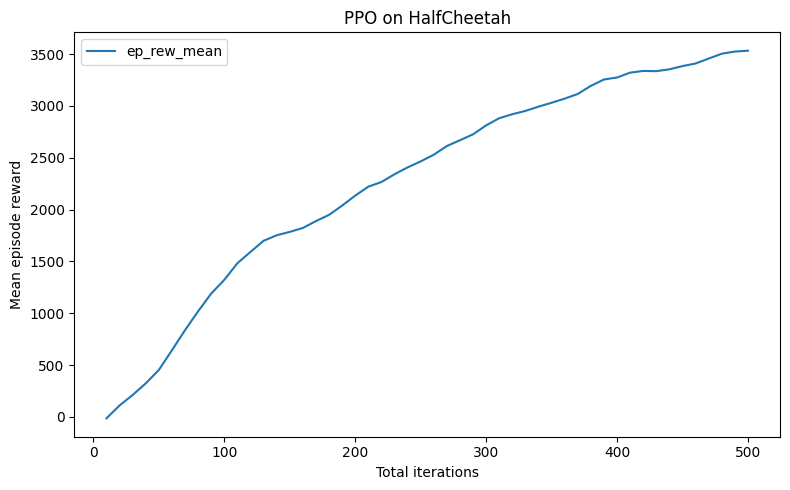

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "logs/progress.csv"

df = pd.read_csv(csv_path)

# typical SB3 columns:
# - "time/total_timesteps"  (x-axis)
# - "rollout/ep_rew_mean"   (y-axis)

x = df["time/iterations"]
y = df["rollout/ep_rew_mean"]

plt.figure(figsize=(8,5))
plt.plot(x, y, label="ep_rew_mean")
plt.xlabel("Total iterations")
plt.ylabel("Mean episode reward")
plt.title("PPO on HalfCheetah")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

env = Monitor(gym.make("HalfCheetah-v4"))

#########################################
#TODO 5: Change the parameter yourself to finish training
#########################################

model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(
        log_std_init=-2,
        ortho_init=False,
        activation_fn=nn.ReLU,
        net_arch=dict(pi=[256, 256], vf=[256, 256]),
    ),
    # PPO clipping parameter
    clip_range=0.2,
    # entropy coefficient
    ent_coef=3e-4,
    # GAE lambda parameter
    gae_lambda=0.95,
    gamma=0.99,
    learning_rate=3e-4,
    max_grad_norm=0.5,
    n_steps=2048,
    batch_size=256,
    # number of epochs when optimizing one batch
    n_epochs=10,
    device="cpu",
    # value function coefficient in the loss
    vf_coef=0.5,
    verbose=1,
    seed=42
)

new_logger = configure("logs", ["csv"])
model.set_logger(new_logger)

n_envs = model.n_envs
n_steps = model.n_steps
total_ts = 500 * n_steps * n_envs

print("Starting learning...")
# This can take around 10 minutes on a Mac laptop
model.learn(total_ts, log_interval=10)
print("Learning finished.")
model.save(save)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Using cpu device
Wrapping the env in a DummyVecEnv.
Starting learning...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


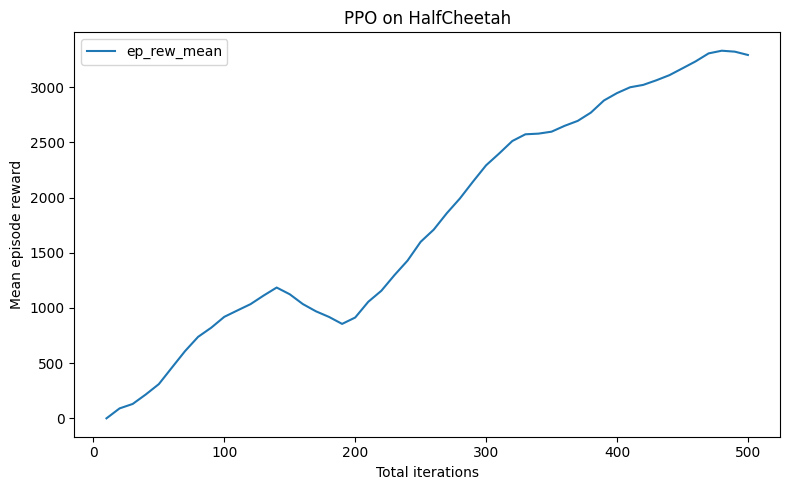

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "logs/progress1.csv"

df = pd.read_csv(csv_path)

# typical SB3 columns:
# - "time/total_timesteps"  (x-axis)
# - "rollout/ep_rew_mean"   (y-axis)

x = df["time/iterations"]
y = df["rollout/ep_rew_mean"]

plt.figure(figsize=(8,5))
plt.plot(x, y, label="ep_rew_mean")
plt.xlabel("Total iterations")
plt.ylabel("Mean episode reward")
plt.title("PPO on HalfCheetah")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

env = Monitor(gym.make("HalfCheetah-v4"))

#########################################
#TODO 5: Change the parameter yourself to finish training
#########################################

model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(
        log_std_init=-2,
        ortho_init=False,
        activation_fn=nn.ReLU,
        net_arch=dict(pi=[256, 256], vf=[256, 256]),
    ),
    # PPO clipping parameter
    clip_range=0.2,
    # entropy coefficient
    ent_coef=3e-4,
    # GAE lambda parameter
    gae_lambda=0.95,
    gamma=0.99,
    learning_rate=3e-4,
    max_grad_norm=0.5,
    n_steps=4096,
    batch_size=256,
    # number of epochs when optimizing one batch
    n_epochs=10,
    device="cpu",
    # value function coefficient in the loss
    vf_coef=0.5,
    verbose=1,
    seed=42
)

new_logger = configure("logs", ["csv"])
model.set_logger(new_logger)

n_envs = model.n_envs
n_steps = model.n_steps
total_ts = 500 * n_steps * n_envs

print("Starting learning...")
# This can take around 10 minutes on a Mac laptop
model.learn(total_ts, log_interval=10)
print("Learning finished.")
model.save(save)


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Using cpu device
Wrapping the env in a DummyVecEnv.
Starting learning...


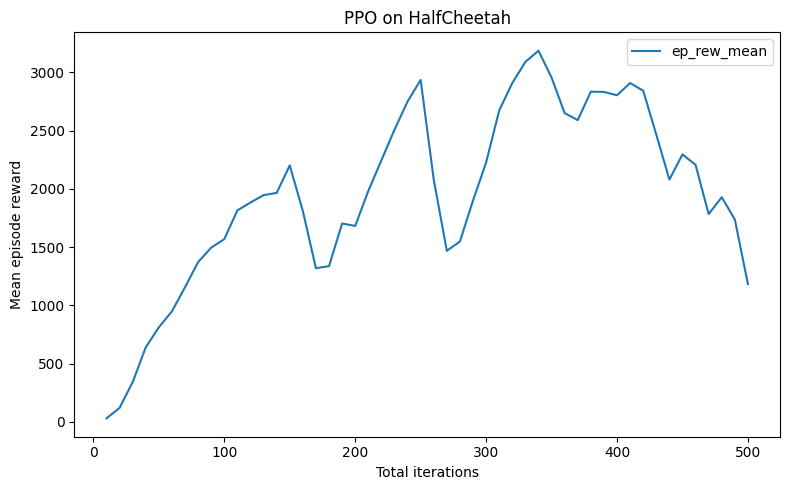

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "logs/progress1.csv"

df = pd.read_csv(csv_path)

# typical SB3 columns:
# - "time/total_timesteps"  (x-axis)
# - "rollout/ep_rew_mean"   (y-axis)

x = df["time/iterations"]
y = df["rollout/ep_rew_mean"]

plt.figure(figsize=(8,5))
plt.plot(x, y, label="ep_rew_mean")
plt.xlabel("Total iterations")
plt.ylabel("Mean episode reward")
plt.title("PPO on HalfCheetah")
plt.legend()
plt.tight_layout()
plt.show()




* **Run 1 (very small lr=2.5e-5, gamma=0.98, lambda=0.92, n_steps≈2048, 20 epochs):** The curve climbs slowly but very smoothly and finishes highest. Tiny policy steps with more epochs act like a strong trust region where updates are conservative, so here we don’t see big dips or collapses. It’s stable but sample-inefficient.

* **Run 2 (lr=3e-4, gamma=0.99, lambda=0.95, n_steps=2048, 10 epochs, batch=256):** We see faster early learning with a small mid-training dip, then steady improvement to a strong final score. Bigger steps make training more sample-efficient than Run 1, but we do also see mild oscillations. This looks like some speed–stability trade-off.

* **Run 3 (same as Run 2 but n_steps=4096):** Learning becomes spiky and regresses late. Longer rollouts mean the policy we optimize is farther from the one that generated data so PPO’s clipping is stressed. Overall there is more instability.

The more standard config (Run 2) is best for HalfCheetah on CPU: n_steps≈2048, batch≈256, lr≈3e-4, gamma=0.99, lambda=0.95. Thus we can see that if we want stability, we can lower the learning rate or raise entropy. And if we want speed and are ok with some risk, we can use larger batches or fewer epochs but we do have to keep rollout length moderate to avoid what we see in run 3. Thus there are considerations to make with all parameters depending on what our goal is!


THIS IS NOT WORKING

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
import torch
from torch import nn

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

save = "ckpt/half_cheetah_ppo"

# Load and test saved model
import time
env = gym.make("HalfCheetah-v4", render_mode="human")
env.reset()
# env = gym.make("racetrack-fast-v0", render_mode="rgb_array")
model = PPO.load(save)

while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    time.sleep(0.1)
  # env.render()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
